In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as hd

fn =  '../data/anomaly.h5'
N = 10000
p = 700

In [2]:
df = pd.read_hdf(fn,stop=N)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(10000, 2101)
Memory in GB: 0.15661120414733887


In [3]:
y = df.iloc[:, -1].values
X = df.iloc[:,:-1].values
X = np.reshape(X, (N, p, 3))
Bs, Ss = [], []
for arr,events in [(Bs, X[y==0]), (Ss, X[y==1])]:
    for i,x in enumerate(events):
        # ignore padded particles and removed particle id information
        x = x[x[:,0] != 0]

        # center jet according to pt-centroid
        yphi_avg = np.average(x[:,1:3], weights=x[:,0], axis=0)
        x[:,1:3] -= yphi_avg

        # mask out any particles farther than R=0.4 away from center (rare)
        # add to list
        x = sorted(x, key=lambda a: a[0], reverse=True)
        x = np.array(x[:100])
        arr.append(x)


Using TensorFlow backend.


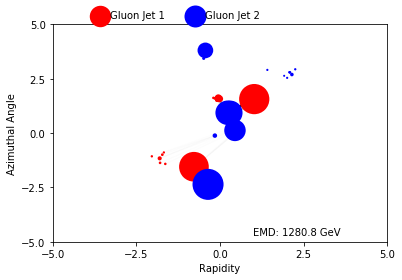

In [4]:
# choose interesting events
from energyflow.emd import emd, emds
import matplotlib.pyplot as plt

ev0, ev1 = Ss[0], Ss[15]

# calculate the EMD and the optimal transport flow
R = 5
emdval, B = emd(ev0, ev1, R=R, return_flow=True)

# plot the two events
colors = ['red', 'blue']
labels = ['Gluon Jet 1', 'Gluon Jet 2']
for i,ev in enumerate([ev0, ev1]):
    pts, ys, phis = ev[:,0], ev[:,1], ev[:,2]
    plt.scatter(ys, phis, marker='o', s=2*pts, color=colors[i], lw=0, zorder=10, label=labels[i])
    
# plot the flow
mx = B.max()
xs, xt = ev0[:,1:3], ev1[:,1:3]
for i in range(xs.shape[0]):
    for j in range(xt.shape[0]):
        if B[i, j] > 0:
            plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                     alpha=B[i, j]/mx, lw=1.25, color='black')

# plot settings
plt.xlim(-R, R); plt.ylim(-R, R)
plt.xlabel('Rapidity'); plt.ylabel('Azimuthal Angle')
plt.xticks(np.linspace(-R, R, 5)); plt.yticks(np.linspace(-R, R, 5))

plt.text(0.6, 0.03, 'EMD: {:.1f} GeV'.format(emdval), fontsize=10, transform=plt.gca().transAxes)
plt.legend(loc=(0.1, 1.0), frameon=False, ncol=2, handletextpad=0)

plt.show()

In [5]:
data = Bs + Ss
emds = emds(data, R=R, norm=True, verbose=1, n_jobs=1, print_every=10000)

Computed 0 EMDs, 0.00% done in 0.00s


KeyboardInterrupt: 

In [11]:
import networkx as nx
import pickle
import numpy as np

def get_training_data():
	# import the knn graph and the partitions
	G = nx.read_gpickle('pickles/knn_graph.gpickle')
	partitions = nx.read_gpickle('pickles/graph_partitions.pickle')
	N = len(G.nodes())
	M = len(partitions)

	# load the training data
	points = pickle.load(open('pickles/points.pickle', 'rb'))
	assert len(points) == N

	# flatten each training point's feature matrix into a single feature vector
	# note that not every collision event may have the same number of particles
	num_particles = 0
	for point in points:
		num_particles = max(num_particles, point.shape[0])
	num_readings = points[0].shape[1] # every particle should have the same number (3) of readigns

	X = []
	for point in points:
		feature = np.copy(point)
		feature.resize((num_particles*num_readings))
		X.append(feature)
	X = np.array(X)

	# create labels for each node
	labels = {}
	for i, part in enumerate(partitions):
		for node in part:
			labels[node] = i

	# turn the labels into soft labels
	# for this, the label becomes the empirical distribution of the part that each node's S nearest neighbors belong to
	nns = nx.read_gpickle('pickles/nearest_neighbors.pickle')
	Y = []
	for i in range(N):
		distribution = np.zeros(M)
		for n in nns[i]:
			distribution[labels[n]] += 1
		distribution = np.divide(distribution, np.sum(distribution))
		Y.append(distribution)
	Y = np.array(Y)

	return X, Y

X, y = get_training_data()
print(X.shape, y.shape)

(1000, 300) (1000, 16)


In [38]:
from sklearn.neighbors import LSHForest
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from tqdm import tqdm_notebook as tqdm
from energyflow.emd import emd, emds

import time

avg_times_exact = {}
std_times_exact = {}

n_samples_values = [750]
D = pickle.load(open('pickles/distances.pickle', 'rb'))
p = pickle.load(open('pickles/points.pickle', 'rb'))

def dfunc(x, y):
    x, y = x.reshape(100, 3), y.reshape(100, 3)
    return emd(x, y)
    
metric = DistanceMetric.get_metric('pyfunc', func=dfunc)
nb = NearestNeighbors(metric=dfunc, algorithm='ball_tree')
nb.fit(X[:750])
k_values = [1]
q_values = [1, 5, 10, 50, 100, 250]
for k in k_values:
    for q in tqdm(q_values):
        times = []
        for i in range(1):
            start = time.time()
            nb.kneighbors(X[1000-q:], n_neighbors=k)
            end = time.time()
            times.append(end-start)
        avg_times_exact[q] = np.mean(times)
        std_times_exact[q] = np.std(times)
        
print(avg_times_exact)
print(std_times_exact)

{1: 1.262902021408081, 5: 7.448821067810059, 10: 12.75058627128601, 50: 69.90071892738342, 100: 114.27327489852905, 250: 275.2230269908905}
{1: 0.0, 5: 0.0, 10: 0.0, 50: 0.0, 100: 0.0, 250: 0.0}


(4000, 8, 2)


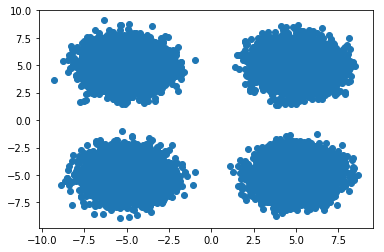